# 過去10日間のデータから当日上昇するか否かを予測するモデル

「E-MiniS&P500-daily-DM-01.ipynb」の実験結果をもとに使用する特徴量を絞って再度同じ検証をしてみる。
使用する特徴量は
- OI
- Vol

- CLDiff
- HLDiff
- HCDiff

- OISlope
- VSlope
- LSlope
- CSlope
- CLSlope
- HCSlope

## モデル

- ロジスティック回帰
- ランダムフォレスト
- 線形SVM
- 非線形SVM

# 結論
- 特徴量をしぼっても過学習の問題は避けられなかった。「E-MiniS&P500-daily-DM-01.ipynb」のときと結果はほぼ同じで、木の数を増やすなどモデルを柔軟にすれば、学習データにフィットするがテストデータではランダム。モデルの柔軟性を下げると、学習データのフィットは悪くなり、テストデータではやはりランダム。
- 今回は、まずは有用な特徴量だけを使うことで過学習を抑制できると考えた。そこで「E-MiniS&P500-daily-DM-01.ipynb」のテストデータ性能がどうであれ、様々なパラメータの組み合わせを試して重要度が高かった特徴量はやはり重要なのではないかと考えて、今回の学習にそれらの特徴量だけを使うというやり方をしたが、この仮説を支持することはできなかった。
    - 原因としては３つ考えられる。
        1. 極端な過学習という問題を、重要な特徴量に絞っても抑制できなかったため、その特徴量が実際に重要だったのかどうかを判断できない。
        2. 汎化性能が皆無のモデルで重要度が高かった特徴量は、実際に重要な特徴量ではない。
        3. 特徴量の重要度の測り方に問題があった。なぜなら、どの特徴量も非常に重要度の値は小さかったため、差があったとは言えない可能性がある。
- いずれにしても、1番目より、そもそも今回の方法では２つのこと、つまり「重要な特徴量だけを使えば過学習を抑制することができる」と「今回の方法で重要な特徴量を選別することができる」という2つのことを同時に仮定してしまっているため、このやり方だけでは結論を導くことができない。
- 特徴量の選別については、おそらく以下の方法で探すのが効率的だろう。
    1. 経験豊富なトレーダーの意見
    2. データマイニング
- そこで、1.に対しては、引き続き本を読んでアイディアを集めることともう一つは、自分自身もまずは裁量トレードの経験を積んで勘を養う。2.に対しては、複数モデル × 複数データの組み合わせで片っ端から学習させてみることでよい汎化性能を持つモデルとデータの組み合わせを探索するデータマイニングシステムを構築して、特徴量を探索する。

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy
import scipy.stats as st
import statsmodels.stats.anova as anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import datetime as dt
from dateutil.relativedelta import relativedelta
import locale

import finalib as fl

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

# データ読み込み

- E-MiniS&P500の日足データ（TradeStationからエクスポートしたもの）
- 最新の限月価格を基準にして過去の限月価格との差額を単純に過去限月価格に足して限月間のずれを解消したつなぎ足データ
    - 単純な方法でよく用いられるが、過去限月の価格が0以下になることがある
    - 今回のデータでは、Open, High, Low, Closeで0以下の値はない

In [4]:
base_dir = 'data/e-mini-sp500-200530'
df_raw = pd.read_csv(f'{base_dir}/e-mini-sp500-daily.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5729 entries, 0 to 5728
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5729 non-null   object 
 1   Time    5729 non-null   object 
 2   Open    5729 non-null   float64
 3   High    5729 non-null   float64
 4   Low     5729 non-null   float64
 5   Close   5729 non-null   float64
 6   Vol     5729 non-null   int64  
 7   OI      5729 non-null   int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 358.2+ KB


# ベースデータ作成

- 過去10足分まで見れるデータにする
- 二次的指標の追加
    - 「E-MiniS&P500-daily-DM-01.ipynb」の実験結果をもとに絞った特徴量を追加

In [5]:
# 過去N足分まで見れるデータにする

# 何足分見るか
N_BARS = 10

df = fl.make_nbars(df_raw, N_BARS, cols=['Open', 'High', 'Low', 'Close', 'Vol', 'OI'])
#fl.make_nbars(df_raw[:21], 10)
df.head(3)

,Date,Time,Open10,High10,Low10,Close10,Vol10,OI10,Open9,High9,...,Low1,Close1,Vol1,OI1,Open0,High0,Low0,Close0,Vol0,OI0
0,09/25/1997,17:00,1071.25,1082.25,1062.75,1068.50,11825,2909,1070.50,1089.00,...,1104.5,1106.00,14580.0,6194.0,1106.25,1110.0,1098.00,1099.25,14114.0,6132.0
1,09/26/1997,17:00,1070.50,1089.00,1066.00,1071.25,9759,4059,1086.00,1092.25,...,1098.0,1099.25,14114.0,6132.0,1099.00,1109.0,1099.00,1106.00,12049.0,5666.0
2,09/29/1997,17:00,1086.00,1092.25,1081.50,1083.75,8551,3818,1083.75,1112.50,...,1099.0,1106.00,12049.0,5666.0,1105.75,1117.0,1102.75,1114.50,11104.0,5722.0


In [6]:
# 値動き指標を追加

# イントラバーの値動き
for i in range(N_BARS+1):
    df[f'CODiff{i}'] = df[f'Close{i}'] - df[f'Open{i}'] # 終値 - 始値
    df[f'HLDiff{i}'] = df[f'High{i}'] - df[f'Low{i}'] # 高値 - 安値
    df[f'HCDiff{i}'] = df[f'High{i}'] - df[f'Close{i}'] # 高値 - 終値
    #df[f'OLDiff{i}'] = df[f'Open{i}'] - df[f'Low{i}'] # 始値 - 安値
    df[f'CLDiff{i}'] = df[f'Close{i}'] - df[f'Low{i}'] # 終値 - 安値
    
# 2足間の値動き
for i in range(N_BARS):
    df[f'CSlope{i}'] = df[f'Close{i}'] - df[f'Close{i+1}'] # ある日の終値 - 前日の終値
    df[f'LSlope{i}'] = df[f'Low{i}'] - df[f'Low{i+1}'] # ある日の安値 - 前日の安値
    df[f'VSlope{i}'] = df[f'Vol{i}'] - df[f'Vol{i+1}'] # ある日の出来高 - 前日の出来高
    df[f'OISlope{i}'] = df[f'OI{i}'] - df[f'OI{i+1}'] # ある日の建玉数 - 前日の建玉数
    df[f'HCSlope{i}'] = df[f'High{i}'] - df[f'Close{i+1}'] # ある日の高値 - 前日の終値
    df[f'CLSlope{i}'] = df[f'Close{i+1}'] - df[f'Low{i}'] # ある日の前日の終値 - ある日の安値

In [7]:
# DateをDatetime型にする
df['Date'] = df['Date'].map(lambda s: dt.datetime.strptime(s, '%m/%d/%Y').date())

# 始まりの年月と終わりの年月（終わりは含まない）
s_year, s_month = 1997, 10
e_year, e_month = 2020, 2

df = df[(df['Date'] >= dt.date(s_year,s_month,1)) & (df['Date'] < dt.date(e_year,e_month,1))]
df = df.reset_index(drop=True)
df.info()
print('\n始めのデータ\n', df[:1])
print('\n終わりのデータ\n', df[-1:])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5633 entries, 0 to 5632
Columns: 172 entries, Date to CLSlope9
dtypes: float64(168), int64(2), object(2)
memory usage: 7.4+ MB

始めのデータ
          Date   Time  Open10  High10   Low10  Close10  Vol10  OI10    Open9  \
0  1997-10-01  17:00  1108.5  1115.0  1104.0   1108.5  10849  5516  1108.25   

    High9  ...  VSlope8  OISlope8  HCSlope8  CLSlope8  CSlope9  LSlope9  \
0  1123.0  ...  -1708.0    -286.0      5.25       5.0      2.0     3.25   

   VSlope9  OISlope9  HCSlope9  CLSlope9  
0    739.0     606.0      14.5      1.25  

[1 rows x 172 columns]

終わりのデータ
             Date   Time  Open10   High10    Low10  Close10    Vol10     OI10  \
5632  2020-01-31  17:00  3283.0  3306.75  3282.75  3305.25  1335246  2716639   

       Open9   High9  ...   VSlope8  OISlope8  HCSlope8  CLSlope8  CSlope9  \
5632  3305.5  3319.0  ...  260934.0   20279.0      4.75     17.75      8.5   

      LSlope9  VSlope9  OISlope9  HCSlope9  CLSlope9  
5632     22

In [8]:
# 年列を入れる
df['year'] = df['Date'].map(lambda date: date.year)

# 学習用データ作成

過去10日間の全指標から、当日上昇するか否かを予測するための学習用データ

- `Date`, `Time`, `year`は不要
- 「E-MiniS&P500-daily-DM-01.ipynb」の結果に基づいて、以下は不要
    - `OLDiff`, `CODiff`
- 当日の指標については、`CODiff0`以外は不要
- `CODiff0`から当日上昇する場合は1そうでない場合は0となる二値データ列（`isUp`）を作成
    - その後`CODiff0`も不要

In [9]:
# Up0列追加
# 注意：1なら上昇、0なら横ばいか下降
dfp = df.copy()
#dfp['isUp'] = dfp['CODiff0'].map(lambda x: 1 if x > 0 else 0)
dfp['isUp'] = dfp['CODiff0'] > 0
dfp[['CODiff0', 'isUp']].head(6)

,CODiff0,isUp
0,7.75,True
1,5.50,True
2,6.00,True
3,0.75,True
4,9.25,True
5,-7.50,False


In [10]:
# ポジティブとネガティブで偏りがないか
dfp.groupby('isUp')['isUp'].count()

# あまりない

isUp
False    2613
True     3020
Name: isUp, dtype: int64

In [11]:
# 訓練データを何割にするか
train_ratio = 0.8

train_df, test_df = fl.split_data(dfp, train_ratio, purging=True, n_bars=N_BARS+1)

print(f'もとデータのサンプル数 = {df.shape[0]}')
print(f'訓練データのサンプル数 = {train_df.shape[0]}')
print(f'テストデータのサンプル数 = {test_df.shape[0]}')
print(f'いくつのサンプルがパージされたか：{df.shape[0] - train_df.shape[0] - test_df.shape[0]}')

もとデータのサンプル数 = 5633
訓練データのサンプル数 = 4498
テストデータのサンプル数 = 1125
いくつのサンプルがパージされたか：10


訓練データの期間：1997-10-01 - 2015-07-29
テストデータの期間：2015-08-13 - 2020-01-31


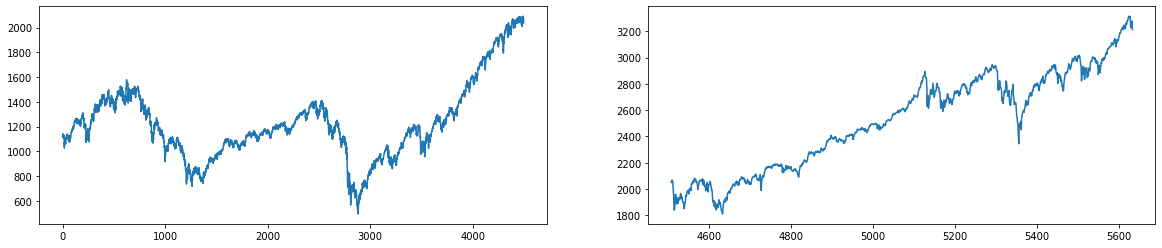

In [12]:
# 各データの期間
print(f"訓練データの期間：{train_df['Date'].iloc[0].strftime('%Y-%m-%d')} - {train_df['Date'].iloc[-1].strftime('%Y-%m-%d')}")
print(f"テストデータの期間：{test_df['Date'].iloc[0].strftime('%Y-%m-%d')} - {test_df['Date'].iloc[-1].strftime('%Y-%m-%d')}")
fix, ax = plt.subplots(1, 2, figsize=(20, 4))
train_df['Close0'].plot(ax=ax[0])
test_df['Close0'].plot(ax=ax[1])

In [13]:
# 不要な列を削除
drop_cols = ['Date','Time','year','Open0','High0','Low0','Close0','Vol0','OI0','CODiff0','HLDiff0',
             'HCDiff0','CLDiff0','CSlope0','LSlope0','VSlope0','OISlope0','HCSlope0','CLSlope0',
             'CODiff1','CODiff2','CODiff3','CODiff4','CODiff5','CODiff6','CODiff7','CODiff8','CODiff9','CODiff10'
             ]
drop_cols = drop_cols \
            + [f'Open{i}' for i in range(1,11)] \
            + [f'High{i}' for i in range(1,11)] \
            + [f'Low{i}' for i in range(1,11)] \
            + [f'Close{i}' for i in range(1,11)]
train_data = train_df.drop(drop_cols, axis=1)
test_data = test_df.drop(drop_cols, axis=1)

# 入力と出力

In [14]:
x_train = train_data.drop(['isUp'], axis=1)
y_train = train_data['isUp']

x_test = test_data.drop(['isUp'], axis=1)
y_test = test_data['isUp']

# ロジスティック回帰

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
lrm = LogisticRegression()
lrm.fit(x_train, y_train)

y_pred_train_lrm = lrm.predict(x_train)

pritn('score = ', lrm.)
print('traininig accuracy = ', accuracy_score(y_true=y_train, y_pred=y_pred_train_lrm))
print("coefficient = ", lrm.coef_)
print("intercept = ", lrm.intercept_)

traininig accuracy =  0.5411293908403735
coefficient =  [[-6.78806415e-08  8.64945260e-08 -9.59534184e-09  9.15418372e-08
   7.48577751e-09  3.37474310e-08  1.01271071e-08  6.66155186e-08
  -1.16640886e-08  1.88800741e-07  3.44399847e-08 -1.59390416e-07
   3.12433829e-08 -1.21577399e-08 -4.02822975e-08 -7.50745142e-08
  -1.21347993e-08  2.72036104e-08  6.06981687e-08 -1.65859167e-07
  -1.61499984e-11  5.69655301e-11 -7.31155285e-11 -2.04936446e-11
  -4.38518968e-12 -1.61084549e-11 -3.59121386e-11 -2.86577241e-11
  -7.25441452e-12 -8.79635341e-12  2.67480757e-11 -3.55444291e-11
  -4.86231569e-11 -1.06249415e-11 -3.79982153e-11 -2.01401027e-12
   2.82192009e-11 -3.02332112e-11 -2.96760164e-11  3.22454273e-11
  -6.19214438e-11 -5.30108900e-11 -6.70560608e-11  1.40451708e-11
   2.98118816e-11  3.24739561e-11 -2.66207450e-12  1.18748145e-14
  -1.28047187e-11  1.28165935e-11 -7.21324657e-11 -1.51253922e-11
   7.28329680e-08 -1.93062777e-07 -1.51669356e-11 -9.83062756e-13
  -1.60606760e-11 -7

In [16]:
# テスト
y_pred_lr = lrm.predict(x_test)

print('confusion matrix = \n', confusion_matrix(y_true=y_test, y_pred=y_pred_lr))
print('accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred_lr))
print('precision = ', precision_score(y_true=y_test, y_pred=y_pred_lr))
print('recall = ', recall_score(y_true=y_test, y_pred=y_pred_lr))
print('f1 score = ', f1_score(y_true=y_test, y_pred=y_pred_lr))
print(classification_report(y_test, y_pred_lr))

confusion matrix = 
 [[ 63 438]
 [ 57 567]]
accuracy =  0.56
precision =  0.564179104477612
recall =  0.9086538461538461
f1 score =  0.696132596685083
              precision    recall  f1-score   support

       False       0.53      0.13      0.20       501
        True       0.56      0.91      0.70       624

    accuracy                           0.56      1125
   macro avg       0.54      0.52      0.45      1125
weighted avg       0.55      0.56      0.48      1125



# ランダムフォレスト

In [76]:
from sklearn.ensemble import RandomForestClassifier
rfm = RandomForestClassifier()
rfm.fit(x_train, y_train)

y_pred_train_rfm = lrm.predict(x_train)

print('traininig accuracy = ', accuracy_score(y_true=y_train, y_pred=y_pred_train_rfm))

traininig accuracy =  0.5411293908403735


In [77]:
# テスト
y_pred_rf = rfm.predict(x_test)

print('confusion matrix = \n', confusion_matrix(y_true=y_test, y_pred=y_pred_rf))
print('accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred_rf))
print('precision = ', precision_score(y_true=y_test, y_pred=y_pred_rf))
print('recall = ', recall_score(y_true=y_test, y_pred=y_pred_rf))
print('f1 score = ', f1_score(y_true=y_test, y_pred=y_pred_rf))
print(classification_report(y_test, y_pred_lr))

confusion matrix = 
 [[214 287]
 [247 377]]
accuracy =  0.5253333333333333
precision =  0.5677710843373494
recall =  0.6041666666666666
f1 score =  0.5854037267080744
              precision    recall  f1-score   support

       False       0.53      0.13      0.20       501
        True       0.56      0.91      0.70       624

    accuracy                           0.56      1125
   macro avg       0.54      0.52      0.45      1125
weighted avg       0.55      0.56      0.48      1125



# ランダムフォレスト（バギング）でグリッドサーチ

In [92]:
from sklearn.model_selection import GridSearchCV
params = {
    'n_estimators': [5, 10, 15, 20, 30, 50, 70],
    'max_depth': [2, 3, 5, 7, 10, 20, 40],
    'min_samples_split': [2, 5, 10, 15, 20, 40],
    'min_samples_leaf': [1, 5, 10, 20, 30],
}
pkf = fl.PurgedKFold(n_splits=10, n_overlaps=10, pct_embargo=0.05)
rfcv = GridSearchCV(rfm, params, cv=pkf, n_jobs=-1, verbose=1)
rfcv.fit(x_train, y_train)

Fitting 10 folds for each of 1470 candidates, totalling 14700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 334 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 1534 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3534 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4834 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 6334 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 7212 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 8162 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 9212 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 10362 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 11612 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 12962 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 14412 tasks   

GridSearchCV(cv=PurgedKFold(n_overlaps=10, n_splits=10, pct_embargo=0.05),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_...
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
    

In [93]:
from sklearn.metrics import accuracy_score
rf_best = rfcv.best_estimator_
print('best parameters:', rfcv.best_params_)

y_pred_tr = rf_best.predict(x_train)
print(f'training accuracy: {accuracy_score(y_train, y_pred_tr)}')

y_pred_te = rf_best.predict(x_test)
print(f'test accuracy: {accuracy_score(y_test, y_pred_te)}')

best parameters: {'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 5}
training accuracy: 0.5651400622498889
test accuracy: 0.5333333333333333


## 学習済みモデルから、特徴量の重要度を確認する

In [94]:
feat_scores = zip(x_test.columns, list(rf_best.feature_importances_))
feat_scores_ranking = sorted(feat_scores, key=lambda x: x[1], reverse=True)
for name, feat in feat_scores_ranking[:10]:
    print(f'{name:10s} : {feat:.05f}')

CSlope2    : 0.06675
Vol1       : 0.06602
HCDiff3    : 0.06459
OI5        : 0.06434
CSlope7    : 0.05525
OI4        : 0.05313
HLDiff10   : 0.04869
CLDiff1    : 0.04862
HCSlope4   : 0.04761
OI10       : 0.04080


# ランダムフォレスト（AdaBoost）でグリッドサーチ

In [108]:
from itertools import product
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import AdaBoostClassifier
dtc_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 3, 5, 7, 10, 20, 40],
    'min_samples_split': [2, 3, 5, 10, 15, 20, 40],
    'min_samples_leaf': [1, 2, 5, 10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2', None],
}
param_prods = product(dtc_params['criterion'],
                     dtc_params['max_depth'],
                     dtc_params['min_samples_split'],
                     dtc_params['min_samples_leaf'],
                     dtc_params['max_features'],
                     )
dtcs = [DTC(criterion=c, max_depth=d, min_samples_split=s, min_samples_leaf=l, max_features=f) for c, d, s, l, f in param_prods]

params = {
    'base_estimator': dtcs,
    'n_estimators': [5],
    'learning_rate': [1],
}
abc = AdaBoostClassifier()
pkf = fl.PurgedKFold(n_splits=10, n_overlaps=10, pct_embargo=0.05)
abccv = GridSearchCV(abc, params, cv=pkf, n_jobs=-1, verbose=1)
abccv.fit(x_train, y_train)

Fitting 10 folds for each of 2688 candidates, totalling 26880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 840 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 1540 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 2440 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 3540 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4840 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 6340 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 7422 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 8372 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 9422 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 10572 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 11822 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 13172 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 17382 tasks   

GridSearchCV(cv=PurgedKFold(n_overlaps=10, n_splits=10, pct_embargo=0.05),
             error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'base_estimator': [DecisionTreeClassifier(ccp_alpha=0.0,
                                                                   class_weight=None,
                                                                   criterion='gini',
                                                                   max_depth=1...
                                                                   max_depth=1,
                                                                   max_features='sqrt',
                                                                   max_leaf_nodes=No

In [109]:
ab_best = abccv.best_estimator_
print('best parameters:', abccv.best_params_)

y_pred_tr = ab_best.predict(x_train)
print(f'training accuracy: {accuracy_score(y_train, y_pred_tr)}')

y_pred_te = ab_best.predict(x_test)
print(f'test accuracy: {accuracy_score(y_test, y_pred_te)}')

best parameters: {'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'), 'learning_rate': 1, 'n_estimators': 5}
training accuracy: 0.565584704313028
test accuracy: 0.5404444444444444


In [110]:
feat_scores = zip(x_test.columns, list(ab_best.feature_importances_))
feat_scores_ranking = sorted(feat_scores, key=lambda x: x[1], reverse=True)
for name, feat in feat_scores_ranking[:10]:
    print(f'{name:10s} : {feat:.05f}')

CSlope3    : 0.11435
OISlope3   : 0.08953
OI5        : 0.07385
HCSlope5   : 0.07297
VSlope2    : 0.06572
HLDiff5    : 0.06470
OISlope6   : 0.06406
CLDiff1    : 0.05556
Vol7       : 0.05491
VSlope3    : 0.05318


# ランダムフォレスト（XGBoost）でグリッドサーチ

In [22]:
from itertools import product
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
'''params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }'''
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5],
        'subsample': [0.6],
        'colsample_bytree': [0.6],
        'max_depth': [3]
        }

xgb = XGBClassifier(learning_rate=0.02, n_estimators=100, objective='binary:logistic', nthread=1)
pkf = fl.PurgedKFold(n_splits=10, n_overlaps=10, pct_embargo=0.05)
xgbcv = GridSearchCV(xgb, params, cv=pkf, n_jobs=-1, verbose=1)
xgbcv.fit(x_train, y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.1s finished


GridSearchCV(cv=PurgedKFold(n_overlaps=10, n_splits=10, pct_embargo=0.05),
             error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.02, max_delta_step=None,
                                     max_depth=None, min_child_wei...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=-1,
   

In [23]:
xg_best = xgbcv.best_estimator_
print('best parameters:', xgbcv.best_params_)

y_pred_tr = xg_best.predict(x_train)
print(f'training accuracy: {accuracy_score(y_train, y_pred_tr)}')

y_pred_te = xg_best.predict(x_test)
print(f'test accuracy: {accuracy_score(y_test, y_pred_te)}')

best parameters: {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6}
training accuracy: 0.6365051133837261
test accuracy: 0.5395555555555556


In [24]:
feat_scores = zip(x_test.columns, list(xg_best.feature_importances_))
feat_scores_ranking = sorted(feat_scores, key=lambda x: x[1], reverse=True)
for name, feat in feat_scores_ranking[:10]:
    print(f'{name:10s} : {feat:.05f}')

OISlope4   : 0.01401
LSlope6    : 0.01286
VSlope2    : 0.01256
HCDiff2    : 0.01241
CLSlope9   : 0.01194
Vol3       : 0.01178
HCDiff7    : 0.01171
CLDiff4    : 0.01161
Vol1       : 0.01160
Vol4       : 0.01153


In [26]:
xgbcv.best_score_

0.5202881288453963

In [27]:
a = np.array([])
print(type(a))

<class 'numpy.ndarray'>
